# AQUAthon, breakout 2: Navigating the deep

### AQUA fixes and grids definitions, accessing high resolution data, streaming and performance optimization


In this session we will explore some more advanced aspects of AQUA.

The best way to use this notebook is to assume that you have effectively followed [the instructions](https://siili.rahtiapp.fi/#Jupyter-notebooks-with-AQUA) from the  plenary session and requested an interactive job. Please do not try to run this notebook directly on the login node of Lumi or Levante, as most likely there will not be enough memory and cores available.

**A summary of topics covered:**

* [Direct FDB access, dask and parallelization](#direct-fdb-access-dask-and-parallelization)

## Direct FDB access, dask and parallelization

When reading from FDB sources (HPC FDB or Data Bridge) AQUA returns a fully dask-enabled xarray, with all its benefits: parallelization and lazy computation. Let's explore how to profit from these features.
BElow is the slide from Paolo's presentation on monday

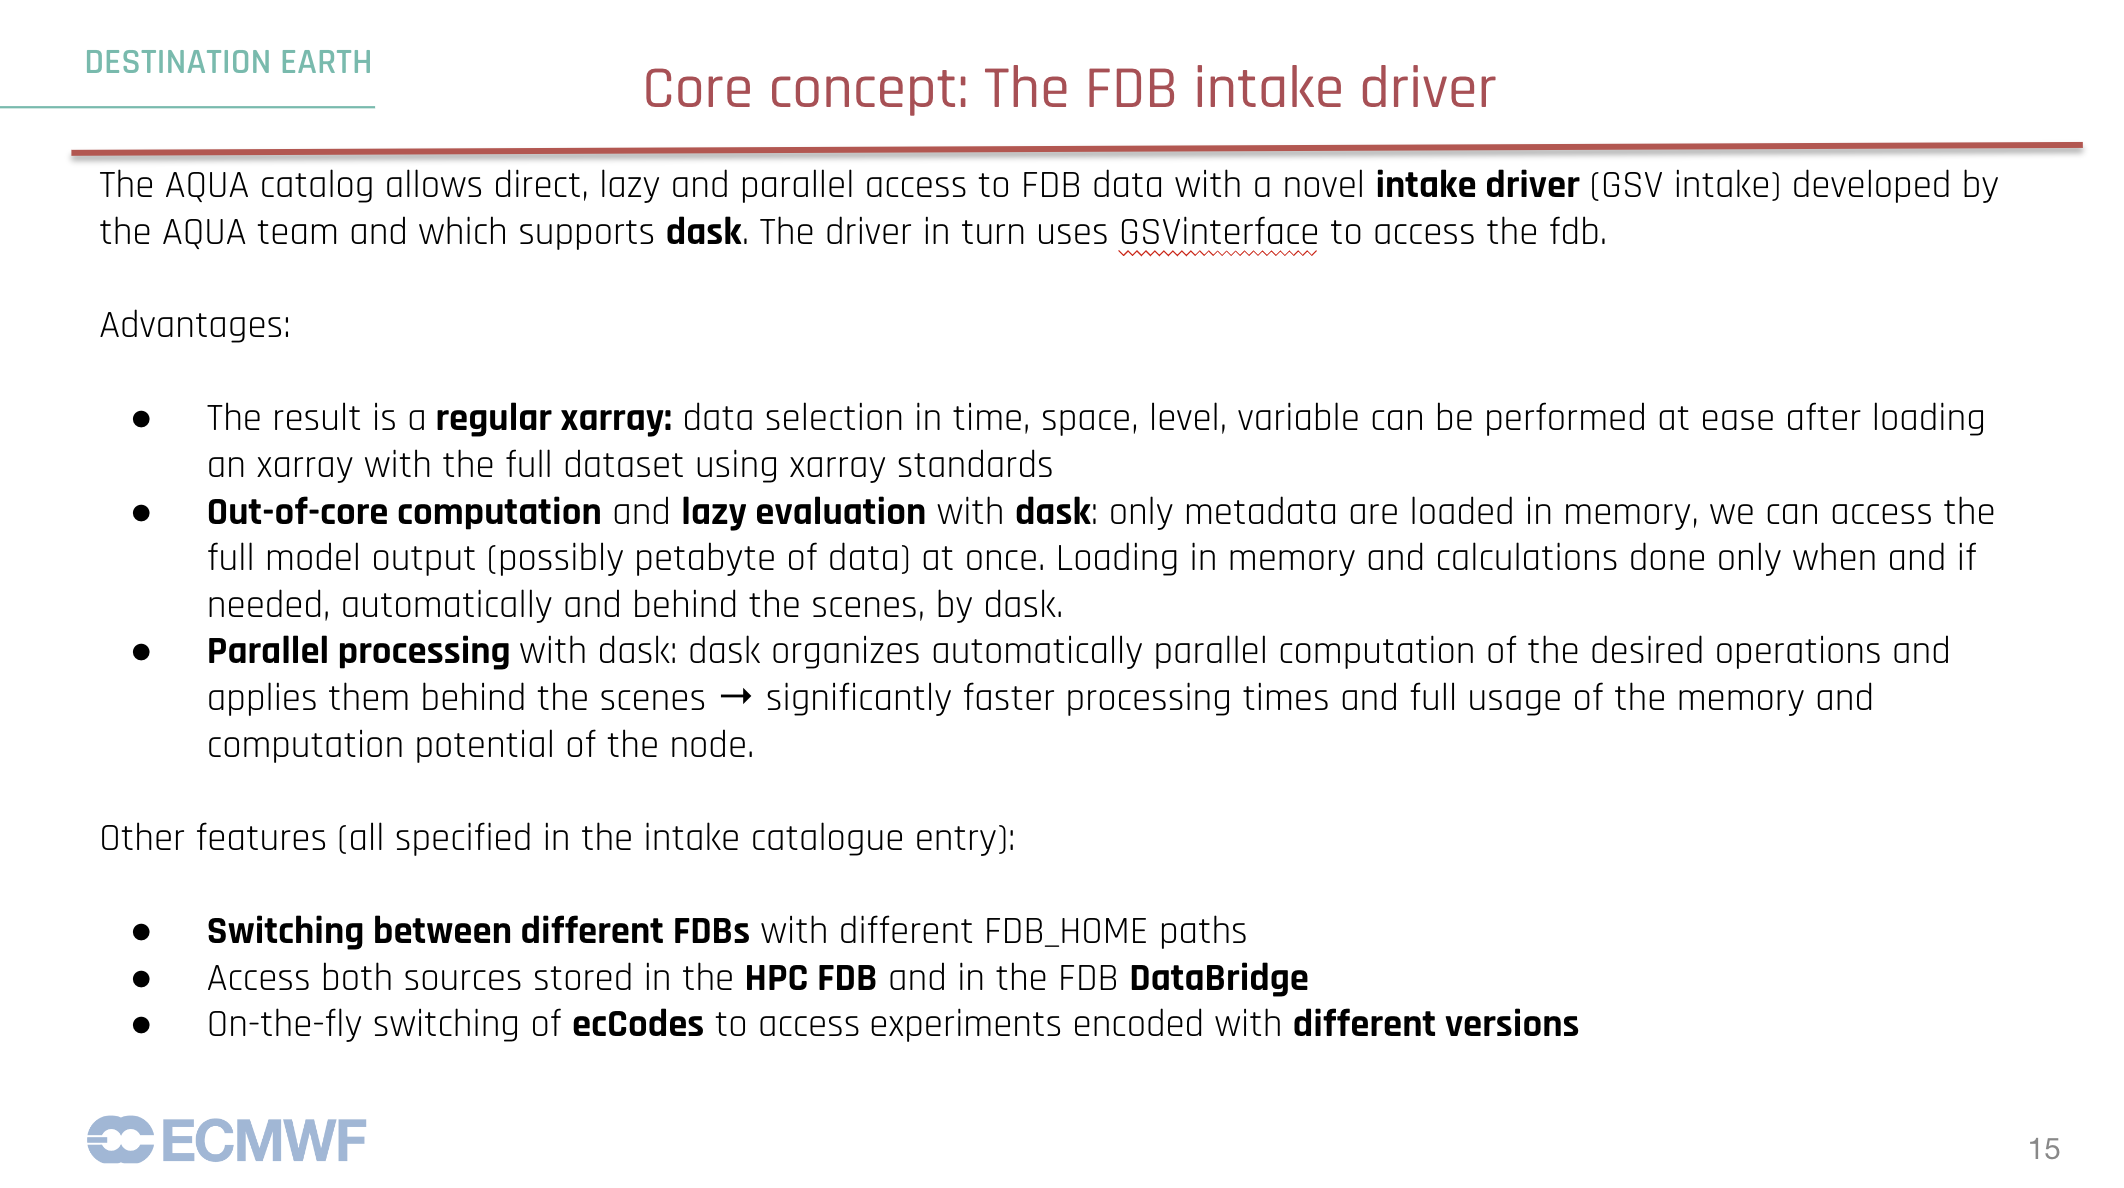

We start by loading some data from a known FDB source

In [2]:
from aqua import Reader

# Adapt for you machine:

# on levante
reader = Reader(catalog="nextgems4", model="IFS-FESOM", exp="ssp370", source="hourly-hpz7-atm2d")

# on lumi
# reader = Reader(catalog="climatedt-phase1", model="IFS-FESOM", exp="ssp370", source="hourly-hpz7-atm2d")

For efficiency we will retrieve only one variable, but you could omit the `var` keyword:

In [4]:
data = reader.retrieve(var="2t")

The result is as usual an xarray **dataset**

In [5]:
data

<xarray.Dataset> Size: 137GB
Dimensions:  (ncells: 196608, time: 87216)
Coordinates:
    lon      (ncells) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
    lat      (ncells) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.2984
  * time     (time) datetime64[ns] 698kB 2020-01-20 ... 2029-12-31T23:00:00
Dimensions without coordinates: ncells
Data variables:
    2t       (time, ncells) float64 137GB dask.array<chunksize=(1, 196608), meta=np.ndarray>
Attributes:
    history:  \n2024-09-06 14:41:46 AQUA💧: Retrieved from IFS-FESOM_ssp370_ho...

If we look more carefully we can see the structure of the data["2t"] DataArray

In [9]:
t2m = data["2t"]
t2m

<xarray.DataArray '2t' (time: 87216, ncells: 196608)> Size: 137GB
dask.array<concatenate, shape=(87216, 196608), dtype=float64, chunksize=(1, 196608), chunktype=numpy.ndarray>
Coordinates:
    lon      (ncells) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
    lat      (ncells) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.2984
  * time     (time) datetime64[ns] 698kB 2020-01-20 ... 2029-12-31T23:00:00
Dimensions without coordinates: ncells
Attributes: (12/20)
    long_name:                       2 metre temperature
    units:                           K
    standard_name:                   air_temperature
    GRIB_paramId:                    167
    GRIB_shortName:                  2t
    GRIB_units:                      K
    ...                              ...
    GRIB_stepUnits:                  1
    GRIB_stepType:                   instant
    GRIB_gridType:                   healpix
    GRIB_gridDefinitionDescription:  150
    gridtype:                        healpix
    history:                         2024-09-06 14:41:46 Dataset retrieved by...

Notice the description "Dask graph	87216 chunks in 436081 graph layers" ....
If we select a specific range of dates, the only those data will be effectively retrieved from the fdb when needed for the calculation, an example of lazy access. Other operations are almost instantaneous

In [14]:
t2m_selected = t2m.sel(time=slice("2021-01-01", "2021-01-31"))
t2m_selected

<xarray.DataArray '2t' (time: 744, ncells: 196608)> Size: 1GB
dask.array<getitem, shape=(744, 196608), dtype=float64, chunksize=(1, 196608), chunktype=numpy.ndarray>
Coordinates:
    lon      (ncells) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
    lat      (ncells) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.2984
  * time     (time) datetime64[ns] 6kB 2021-01-01 ... 2021-01-31T23:00:00
Dimensions without coordinates: ncells
Attributes: (12/20)
    long_name:                       2 metre temperature
    units:                           K
    standard_name:                   air_temperature
    GRIB_paramId:                    167
    GRIB_shortName:                  2t
    GRIB_units:                      K
    ...                              ...
    GRIB_stepUnits:                  1
    GRIB_stepType:                   instant
    GRIB_gridType:                   healpix
    GRIB_gridDefinitionDescription:  150
    gridtype:                        healpix
    history:                         2024-09-06 14:41:46 Dataset retrieved by...

Let's do an operation requiring calculation on some data. Notice that only now the data will be effectively retrieved from the FDB. This will take some time (approx 2 minutes for the full month, here we retrieve only 15 days)

In [ ]:
t2m_fldmean = t2m_selected.isel(time=slice(1,24*31)).aqua.fldmean()

computation is only when you plot


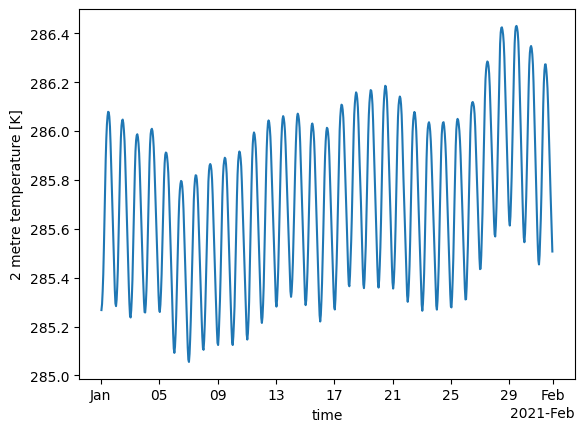

In [36]:
t2m_selected.isel(time=slice(1,24*15)).aqua.fldmean().plot()

This time was spent both in retrieving the data and in computing the field average.

We can accelerate things by considering that we requested a full node with many more cores. We create a local parallel cluster (this needs to be done only once at the beginning of your code). How effective this is will depend on the computational load left for each core.

In [30]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=16, threads_per_worker=1)

and we instantiate a client

In [31]:
client = Client(cluster)

Now we try again

In [32]:
from aqua import Reader
# Adapt for you machine:
# on levante
reader = Reader(catalog="nextgems4", model="IFS-FESOM", exp="ssp370", source="hourly-hpz7-atm2d")
# on lumi
# reader = Reader(catalog="climatedt-phase1", model="IFS-FESOM", exp="ssp370", source="hourly-hpz7-atm2d")
data = reader.retrieve(var="2t")
t2m = data["2t"]
t2m_selected = t2m.sel(time=slice("2021-01-01", "2021-01-31"))

In [34]:
t2m_selected.isel(time=slice(1,24*31)).aqua.fldmean()

<xarray.DataArray '2t' (time: 743)> Size: 6kB
dask.array<truediv, shape=(743,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 6kB 2021-01-01T01:00:00 ... 2021-01-31T23:...
Attributes: (12/20)
    long_name:                       2 metre temperature
    units:                           K
    standard_name:                   air_temperature
    GRIB_paramId:                    167
    GRIB_shortName:                  2t
    GRIB_units:                      K
    ...                              ...
    GRIB_stepUnits:                  1
    GRIB_stepType:                   instant
    GRIB_gridType:                   healpix
    GRIB_gridDefinitionDescription:  150
    gridtype:                        healpix
    history:                         2024-09-06 15:15:08 Dataset retrieved by...

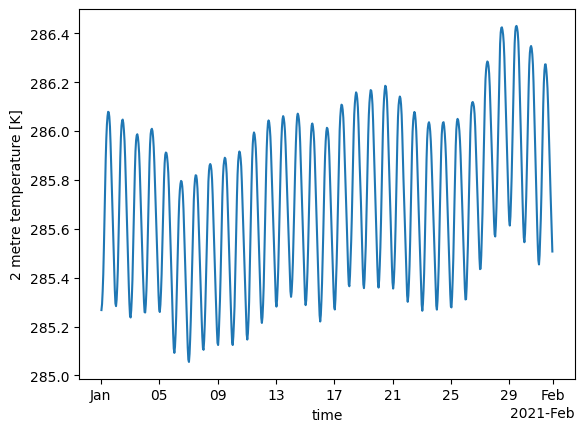

In [33]:
t2m_selected.isel(time=slice(1,24*31)).aqua.fldmean().plot()

Let's not forget to close our cluster and client

In [35]:
client.shutdown()
cluster.close()

XXX Leave an exercise here ?

Should we explain the details 

## The fixer

AQUA can adapt external data to a desired format in terms of variable names, units etc. making it possible for example to transform external observations (e.g. ERA5) into the GSV format on the fly.

As an example, when we load data from CERES or ERA5

notice that the result is already in the same units and variable names as the standard portfolio in the GSV

How does this actually work?

Let's look at an intake catalog source of AQUA in detail

As you will notice this mentions a 'fixer' ... XXXX in this case.

In turn in your `.aqua` folder you will find `.aqua/fixes` containing various 'fixer' files. As an example `IFS-climatedt-v1.yaml` contains:

In [ ]:
fixer_name:
    ifs-destine-v1:
        data_model: ifs
        deltat: 3600
        delete: [tprate]

        vars:
            # Derive precipitation from TP and drop tprate
            mtpr: # https://codes.ecmwf.int/grib/param-db/235055
                nanfirst: true
                source: tp
                grib: true
            # Evaporation and snowfall
            mer: # https://codes.ecmwf.int/grib/param-db/?id=235043
                source: e
                grib: true
                src_units: m
                nanfirst: True # option to fix ifs bug in destine-v1, see below
                #units: kg m**-2 s**-1
            msr: # https://codes.ecmwf.int/grib/param-db/?id=235031
                source: sf
                grib: true
                src_units: m
                nanfirst: True
                #units: kg m**-2 s**-1
            # Latent and sensible heat
            mslhf: # https://codes.ecmwf.int/grib/param-db/?id=235034
                source: slhf
                grib: true
                nanfirst: True
            msshf:
                source: sshf
                grib: true
                nanfirst: True
            # Surface fluxes
            msnswrf:
                source: ssr
                grib: true
                nanfirst: True


XXX Some explanation on one single example ....

XXX Leave an exercise here?

## Section on streaming ?

## Paolo's performance tool?